# 🧠 KoBERT Intent Classification - 실험용

In [8]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, logging as transformers_logging
from transformers import AutoTokenizer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import resample

transformers_logging.set_verbosity_error()

In [9]:
class IntentDataset(Dataset):
    def __init__(self, df, tokenizer, label_encoder, max_len=64):
        self.sentences = df['question'].tolist()
        self.labels = label_encoder.transform(df['intent'].tolist())
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sentences[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class KoBERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(KoBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("skt/kobert-base-v1")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

In [33]:
# 1. 원본 데이터 + 키워드 보강 데이터 불러오기
df_original = pd.read_csv("intent_dataset_cleaned.csv")
df_extra = pd.read_csv("keyword_boost.csv")  # 반드시 포함하고 싶은 키워드 문장 모음

df_combined = pd.concat([df_original, df_extra]).reset_index(drop=True)

# 2. 인텐트별로 균형 조정
TARGET_SAMPLES = 200
balanced_dfs = []

for intent in df_combined['intent'].unique():
    all_intent_df = df_combined[df_combined['intent'] == intent]
    extra_intent_df = df_extra[df_extra['intent'] == intent]

    num_extra = len(extra_intent_df)
    num_to_sample = max(0, TARGET_SAMPLES - num_extra)

    remaining_df = all_intent_df.drop(extra_intent_df.index, errors='ignore')

    if len(remaining_df) >= num_to_sample:
        sampled_df = resample(remaining_df, replace=False, n_samples=num_to_sample, random_state=42)
    else:
        sampled_df = resample(remaining_df, replace=True, n_samples=num_to_sample, random_state=42)

    combined = pd.concat([sampled_df, extra_intent_df])
    balanced_dfs.append(combined)

# 3. 전체 데이터셋 통합
df_balanced = pd.concat(balanced_dfs).reset_index(drop=True)

# 4. 라벨 인코딩 및 분할
label_encoder = LabelEncoder()
label_encoder.fit(df_balanced['intent'])

train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, stratify=df_balanced['intent'], random_state=42
)

# 5. 토크나이저 및 데이터셋 생성
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)

train_dataset = IntentDataset(train_df, tokenizer, label_encoder)
val_dataset = IntentDataset(val_df, tokenizer, label_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 6. 분포 확인
print("✅ Balanced class distribution:")
print(df_balanced['intent'].value_counts())

✅ Balanced class distribution:
intent
arrival_congestion_query           200
departure_congestion_prediction    200
arrival_congestion_prediction      200
airport_weather_current            200
facility_guide                     200
airline_info_query                 200
arrival_policy_info                200
baggage_claim_info                 200
baggage_rule_query                 200
departure_policy_info              200
regular_schedule_query             200
parking_availability_query         200
parking_fee_info                   200
parking_location_recommendation    200
flight_info                        200
parking_query                      200
parking_congestion_prediction      200
transfer_info                      200
transfer_route_guide               200
default_greeting                   200
parking_walk_time_info             200
Name: count, dtype: int64


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KoBERTClassifier(num_labels=len(label_encoder.classes_)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [34]:
print(df_balanced.columns.tolist())

['intent', 'question']


In [36]:
import torch
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import pickle

# 성능 추적용 리스트
train_losses = []
val_accuracies = []
val_confidences = []

best_acc = 0
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"🛠️ Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"📚 Epoch {epoch+1} Loss: {avg_train_loss:.4f}")

    # 🎯 검증
    model.eval()
    preds, targets, confs_all = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="🔍 Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            probs = softmax(logits, dim=1)
            confs, predicted = torch.max(probs, 1)

            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            confs_all.extend(confs.cpu().numpy())

    acc = accuracy_score(targets, preds)
    avg_conf = sum(confs_all) / len(confs_all)
    val_accuracies.append(acc)
    val_confidences.append(avg_conf)

    print(f"🎯 Val Acc: {acc:.4f} | 🔍 Avg Confidence: {avg_conf:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_models/intent-kobert-v1/best_kobert_model.pt")
        print(f"✅ Best model saved! Acc: {acc:.4f}")
        best_report = classification_report(targets, preds,
                                            target_names=label_encoder.classes_,
                                            zero_division=0)

# 💾 최종 best 결과 출력
print(f"\n📈 Best Validation Accuracy: {best_acc:.4f}")
print("📊 Classification Report for Best Model:")
print(best_report)

# 라벨 인코더도 함께 저장
with open("best_models/intent-kobert-v1/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("🔖 Label encoder saved.")


🛠️ Training Epoch 1: 100%|██████████| 210/210 [00:42<00:00,  4.95it/s]


📚 Epoch 1 Loss: 2.3888


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 18.10it/s]


🎯 Val Acc: 0.8310 | 🔍 Avg Confidence: 0.2722
✅ Best model saved! Acc: 0.8310


🛠️ Training Epoch 2: 100%|██████████| 210/210 [00:38<00:00,  5.40it/s]


📚 Epoch 2 Loss: 0.9905


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.74it/s]


🎯 Val Acc: 0.9440 | 🔍 Avg Confidence: 0.6545
✅ Best model saved! Acc: 0.9440


🛠️ Training Epoch 3: 100%|██████████| 210/210 [00:39<00:00,  5.27it/s]


📚 Epoch 3 Loss: 0.3642


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.75it/s]


🎯 Val Acc: 0.9643 | 🔍 Avg Confidence: 0.8728
✅ Best model saved! Acc: 0.9643


🛠️ Training Epoch 4: 100%|██████████| 210/210 [00:39<00:00,  5.35it/s]


📚 Epoch 4 Loss: 0.1667


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.87it/s]


🎯 Val Acc: 0.9655 | 🔍 Avg Confidence: 0.9453
✅ Best model saved! Acc: 0.9655


🛠️ Training Epoch 5: 100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


📚 Epoch 5 Loss: 0.1073


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.79it/s]


🎯 Val Acc: 0.9571 | 🔍 Avg Confidence: 0.9679


🛠️ Training Epoch 6: 100%|██████████| 210/210 [00:39<00:00,  5.32it/s]


📚 Epoch 6 Loss: 0.0822


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.77it/s]


🎯 Val Acc: 0.9679 | 🔍 Avg Confidence: 0.9789
✅ Best model saved! Acc: 0.9679


🛠️ Training Epoch 7: 100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


📚 Epoch 7 Loss: 0.0634


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.81it/s]


🎯 Val Acc: 0.9595 | 🔍 Avg Confidence: 0.9862


🛠️ Training Epoch 8: 100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


📚 Epoch 8 Loss: 0.0515


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.83it/s]


🎯 Val Acc: 0.9619 | 🔍 Avg Confidence: 0.9855


🛠️ Training Epoch 9: 100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


📚 Epoch 9 Loss: 0.0438


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.83it/s]


🎯 Val Acc: 0.9583 | 🔍 Avg Confidence: 0.9905


🛠️ Training Epoch 10: 100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


📚 Epoch 10 Loss: 0.0418


🔍 Validating: 100%|██████████| 53/53 [00:02<00:00, 17.84it/s]

🎯 Val Acc: 0.9643 | 🔍 Avg Confidence: 0.9919

📈 Best Validation Accuracy: 0.9679
📊 Classification Report for Best Model:
                                 precision    recall  f1-score   support

             airline_info_query       1.00      1.00      1.00        40
        airport_weather_current       1.00      1.00      1.00        40
  arrival_congestion_prediction       0.91      1.00      0.95        40
       arrival_congestion_query       1.00      0.88      0.93        40
            arrival_policy_info       0.95      0.93      0.94        40
             baggage_claim_info       0.95      1.00      0.98        40
             baggage_rule_query       0.90      0.93      0.91        40
               default_greeting       1.00      1.00      1.00        40
departure_congestion_prediction       0.98      1.00      0.99        40
          departure_policy_info       1.00      0.93      0.96        40
                 facility_guide       0.97      0.97      0.97        40
  

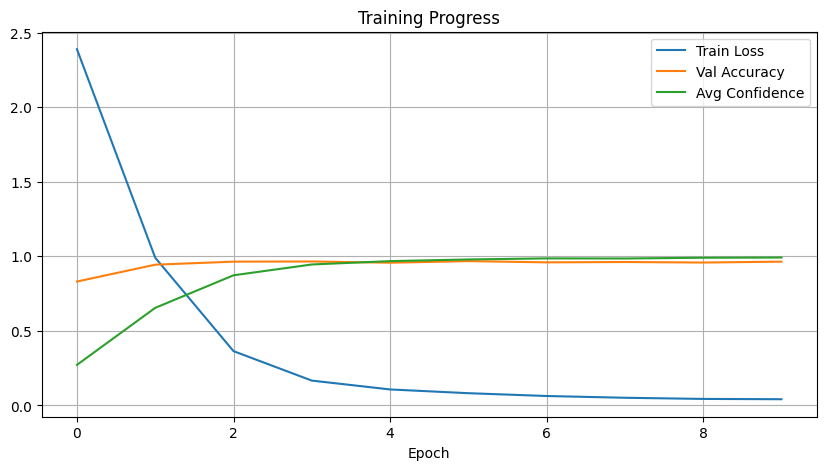

In [37]:
# 📈 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(val_confidences, label='Avg Confidence')
plt.legend()
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

In [38]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from transformers import BertModel
from transformers import AutoTokenizer
import pickle

# 🧠 모델 클래스 정의
class KoBERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(KoBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("skt/kobert-base-v1")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(self.dropout(pooled_output))

# 🔧 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 토크나이저 및 라벨 인코더 로드
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)
with open("best_models/intent-kobert-v1/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# ✅ 모델 로드
model = KoBERTClassifier(num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load("best_models/intent-kobert-v1/best_kobert_model.pt", map_location=device))
model.to(device)
model.eval()

# 🔮 예측 함수
def predict_intent(text):
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=64,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = softmax(outputs, dim=1)
        conf, predicted = torch.max(probs, 1)

    intent = label_encoder.inverse_transform([predicted.item()])[0]
    return intent, conf.item()

# 🔎 테스트
if __name__ == "__main__":
    while True:
        text = input("✉️ 질문을 입력하세요 (종료하려면 'exit'): ")
        if text.lower() == 'exit':
            break
        intent, confidence = predict_intent(text)
        print(f"🔖 예측 인텐트: {intent} | 🔍 Confidence: {confidence:.4f}")


✉️ 질문을 입력하세요 (종료하려면 'exit'): 환승
🔖 예측 인텐트: transfer_route_guide | 🔍 Confidence: 0.5778
✉️ 질문을 입력하세요 (종료하려면 'exit'): 환승정보
🔖 예측 인텐트: transfer_info | 🔍 Confidence: 0.9874
✉️ 질문을 입력하세요 (종료하려면 'exit'): 항공편
🔖 예측 인텐트: flight_info | 🔍 Confidence: 0.9915
✉️ 질문을 입력하세요 (종료하려면 'exit'): 정기 항공
🔖 예측 인텐트: regular_schedule_query | 🔍 Confidence: 0.9918
✉️ 질문을 입력하세요 (종료하려면 'exit'): 주차장
🔖 예측 인텐트: parking_availability_query | 🔍 Confidence: 0.8567
✉️ 질문을 입력하세요 (종료하려면 'exit'): 입국
🔖 예측 인텐트: arrival_policy_info | 🔍 Confidence: 0.9892


KeyboardInterrupt: Interrupted by user